In [146]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords 

# Naive Bayes Classifier: Feedback analysis #

Using data from the Yelp Reviews dataset, let's build a Naive Bayes classifier to classify the sentiment polarity of restaurant reviews (positive or negative). We will start by exploring the data, and then we'll extract some features to start modeling. We will use unigrams to build and test a classifier. To demonstrate the problem of overfitting, the classifier built based on Yelp Review data will be tested on an additional, unseen dataset (as per Lesson 2.7 Challenge). 

To cross-validate and refine the model further, the classifier will be evaluated using 5 folds. Finally, we'll retest it on the unseen dataset to see how well the cross-validation has improved the classifer.

## Overview of the data ##

The dataset of 1000 rows includes just the review text and a sentiment polarity: 1 = positive, 0 = negative.

In [147]:
# Grab and process the raw data.
yelp_raw = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/yelp_labelled.txt', delimiter= '\t', header=None, encoding='utf-8')
yelp_raw.columns = ['review', 'sentiment']
yelp_raw.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


This dataset includes two balanced classes, with 500 observations in each, so we do not need to employ any special sampling strategies.

In [148]:
#Check how many datapoints are in each category.
yelp_raw['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

For our first try, let's construct a set of keywords for negative sentiment. 

In [149]:
keywords_neg = ['suck', 'else', 'wait', 'gross', 'bad', 'waste', 'rude', 'never', 'terrible']

for key in keywords_neg:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp_raw[str(key)] = yelp_raw.review.str.contains(
        ' ' + str(key),
        case=False
    )

Let's check how independent these keywords are with a heatmap. The keywords we've chosen are pretty independent, so we're not violating the assumptions of the model. 

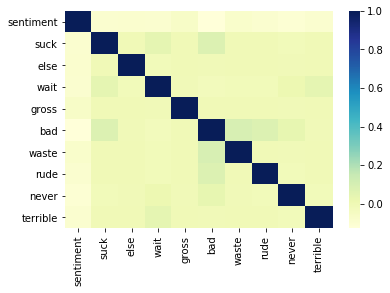

In [150]:
sns.heatmap(yelp_raw.corr(), cmap="YlGnBu")

Next, let's specify the outcome and input variables, and try the model. 

### Iteration 1

In [151]:
data = yelp_raw[keywords_neg]
target = yelp_raw['sentiment']

In [152]:
# For the binary classifier, we'll use a Bernoulli distribution.
from sklearn.naive_bayes import BernoulliNB

# Instantiate the model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred1 = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred1).sum()
))



Number of mislabeled points out of a total 1000 points : 417


So far, the model is faring just a little better than chance, so it needs to be refined. A confusion matrix will narrow in on the model's weakness: sensitivity or specificity. 

In [153]:
from sklearn.metrics import confusion_matrix, f1_score
confusion1 = confusion_matrix(target, y_pred1)
print(confusion1)

type1_error = confusion1[1][0]/(confusion1[1][0]+confusion1[1][1])*100
print(type1_error)

type2_error = confusion1[0][1]/(confusion1[0][0]+confusion1[0][1])*100
print(type2_error)

[[ 94 406]
 [ 11 489]]
2.2
81.2


The model's Type 1 error rate is pretty good: only 11 positive reviews were misclassified as negative reviews (2.2%), while the Type 2 error rate is quite high: 94 negative reviews were missed (18.8%).

### Iteration 2 ###

To refine the model, let's construct a bag of words and examine which unigrams occur most frequently in reviews with each sentiment. We'll start by cleaning and tokenizing the reviews (stripping non-alphabetic characters, casting to lowercase, and separating into words). The CountVectorizer function from sklearn takes care of tokenization. We could manually remove stopwords, but the term frequency - inverse document frequency transformer later should have the same effect.

In [154]:
#Start by removing nonalphabetic characters and converting to lowercase.

yelp_token = yelp_raw['review'].str.replace('[^a-zA-Z]', ' ')
yelp_token = yelp_raw['review'].str.lower()
#words = yelp_token.str.split(' ')

CountVectorizer generates an array where each row is a review from the original dataset, and each column is a word of at least two characters. Each item in the area is a Boolean indicating whether the word is present in that review. Since the highest frequency words contribute little information to the model, we'll transform the dataset so that more informative features are weighted more heavily. 

As we can see from the shape of the array, there are 1000 reviews (the original dataset) and 2034 unigrams.

In [155]:
#Use CountVectorizer to generate an array of unigram counts for each review.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(yelp_token)
#counts = count_vectorizer.fit_transform(data['text'].values)

#Use term frequency - inverse document frequency transformation to weight more informative unigrams.
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(X)
X_tfidf = tfidf_transformer.transform(X)

#Take a look at the shape of the array.
print(X_tfidf.shape)

(1000, 2034)


Next, we'll refit the model using the transformed unigram array instead of the manually constructed list of negative keywords from Iteration 1. This model correctly accounts for 945/1000 datapoints: an accuracy of 94.5%--much better than our first model!

**Question:** How do we test the assumption of independence in a bag of words model like this? What's the best way to look under the hood and see which words are doing the work?

In [156]:
#Refit the model using tfidf in place of the manually constructed keywords list.
bnb.fit(X_tfidf, target)
y_pred2 = bnb.predict(X_tfidf)

#Read out the result.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred2).sum()
))

Number of mislabeled points out of a total 1000 points : 55


Let's evaluate the model using a confusion matrix, to see where it can be improved. The Type 1 and 2 error rates are actually quite similar (5.8% and 5.2%, respectively). This is a really strong model.

In [157]:
#Evaluate the result in a confusion matrix.
confusion2 = confusion_matrix(target, y_pred2)
print(confusion2)

type1_error = confusion2[1][0]/(confusion2[1][0]+confusion2[1][1])*100
print(type1_error)

type2_error = confusion2[0][1]/(confusion2[0][0]+confusion2[0][1])*100
print(type2_error)

[[474  26]
 [ 29 471]]
5.8
5.2


**The big problem**: Since it was constructed using the entire dataset, it suffers from overfitting. The model is built on the basis of all the data in the yelp reviews corpus, so we expect it to fare well with the yelp review corpus. If we apply it to unseen data, say, the Amazon review corpus, we will not expect the same performance. Let's run through the process, fitting the model to the Amazon data, to demonstrate the problem. 

First, read in the Amazon data, and confirm that it has the same content and shape as the Yelp data.

In [158]:
amazon_raw = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/amazon_cells_labelled.txt', delimiter= '\t', header=None, encoding='utf-8')
amazon_raw.columns = ['review', 'sentiment']
print(amazon_raw['sentiment'].value_counts())
amazon_raw.head()

1    500
0    500
Name: sentiment, dtype: int64


,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [159]:
#Create a variable to store the Amazon target data.
target_am = amazon_raw['sentiment']

#Refit the model, using the overfitted features from the Yelp dataset.
bnb.fit(X_tfidf, target_am)
y_pred_am = bnb.predict(X_tfidf)

#Read out the result.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target_am != y_pred_am).sum()
))

#Evaluate the result in a confusion matrix.
confusion_am = confusion_matrix(target_am, y_pred_am)
print(confusion_am)

type1_error = confusion_am[1][0]/(confusion_am[1][0]+confusion_am[1][1])*100
print(type1_error)

type2_error = confusion_am[0][1]/(confusion_am[0][0]+confusion_am[0][1])*100
print(type2_error)

Number of mislabeled points out of a total 1000 points : 119
[[423  77]
 [ 42 458]]
8.4
15.4


Although the model performed very well on its Yelp training data, when confronted with unseen data, its performance isn't quite as good. Its Type 2 error rate jumped to 15.4%: the classifier is not specific enough.

To improve the predictive power of the model, we need to divide the data into a training set and a test set, and cross-validate. Let's go back to the Yelp dataset, and try again.

### Iteration 3 ###

Let's rerun the model, cross-validating it using 5 folds. 

In [160]:
#Collapse the bag of words vectorizer, tfidf transformer, and NB classifier into one operation.

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier',  BernoulliNB()) ])

#Cross-validate using the k-folds method.

from sklearn.cross_validation import KFold

k_fold = KFold(n=len(yelp_raw), n_folds=5)
scores = []
confusion3 = np.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = yelp_raw.iloc[train_indices]['review'].values
    train_y = yelp_raw.iloc[train_indices]['sentiment'].values

    test_text = yelp_raw.iloc[test_indices]['review'].values
    test_y = yelp_raw.iloc[test_indices]['sentiment'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion3 += confusion_matrix(test_y, predictions)
    score3 = f1_score(test_y, predictions)
    scores.append(score3)

print('Total reviews classified:', len(yelp_raw))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion3)

type1_error = confusion3[1][0]/(confusion3[1][0]+confusion3[1][1])*100
print(type1_error)

type2_error = confusion3[0][1]/(confusion3[0][0]+confusion3[0][1])*100
print(type2_error)

Total reviews classified: 1000
Score: 0.762921130068
Confusion matrix:
[[356 144]
 [ 93 407]]
18.6
28.8


After cross-validation over 5 folds of the data, we end up with a much less accurate classifier. Its Type 1 error rate is now 18.6%, and Type 2 error is 28.8%. 

** Question:** Why did it get so much worse with cross-validation? I understand that this means there is less data available for training the model, but this loss of accuracy is pretty bad!

### Iteration 4 ###

That didn't go so well! Let's try again, enriching the model with bigrams. Because of examples like, "not disappointed," simple unigrams (e.g., "disappointed") might not be strong enough. Adding bigrams will increase the model's complexity, but it should improve upon unigrams. 


In [161]:
#Try again, this time with bigrams.

pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('classifier',  BernoulliNB()) ])

#Cross-validate using the k-folds method.

k_fold = KFold(n=len(yelp_raw), n_folds=5)
scores = []
confusion4 = np.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = yelp_raw.iloc[train_indices]['review'].values
    train_y = yelp_raw.iloc[train_indices]['sentiment'].values

    test_text = yelp_raw.iloc[test_indices]['review'].values
    test_y = yelp_raw.iloc[test_indices]['sentiment'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion4 += confusion_matrix(test_y, predictions)
    score4 = f1_score(test_y, predictions)
    scores.append(score4)

print('Total reviews classified:', len(yelp_raw))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion4)

type1_error = confusion4[1][0]/(confusion4[1][0]+confusion4[1][1])*100
print(type1_error)

type2_error = confusion4[0][1]/(confusion4[0][0]+confusion4[0][1])*100
print(type2_error)

Total reviews classified: 1000
Score: 0.742006076294
Confusion matrix:
[[297 203]
 [ 84 416]]
16.8
40.6


Yikes! This result is even worse. With bigrams in the mix, the classifier is misclassifying 40.6% of negative reviews as positive. Why is this the case? 

**NOTE: I don't understand why it's getting so much worse...**

One thing we can try is controlling for the length of the review, binarizing the classifier so that reviews with more instances of a given features are not weighted differently from those with just one instance. Let's try that on the unigram model, and see what happens. 

In [162]:
#Try again, this time with bigrams.

pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier',  BernoulliNB(binarize=0.0)) ])

#Cross-validate using the k-folds method.

k_fold = KFold(n=len(yelp_raw), n_folds=5)
scores = []
confusion5 = np.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = yelp_raw.iloc[train_indices]['review'].values
    train_y = yelp_raw.iloc[train_indices]['sentiment'].values

    test_text = yelp_raw.iloc[test_indices]['review'].values
    test_y = yelp_raw.iloc[test_indices]['sentiment'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion5 += confusion_matrix(test_y, predictions)
    score5 = f1_score(test_y, predictions)
    scores.append(score4)

print('Total reviews classified:', len(yelp_raw))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion5)

type1_error = confusion5[1][0]/(confusion5[1][0]+confusion5[1][1])*100
print(type1_error)

type2_error = confusion5[0][1]/(confusion5[0][0]+confusion5[0][1])*100
print(type2_error)

Total reviews classified: 1000
Score: 0.436363636364
Confusion matrix:
[[356 144]
 [ 93 407]]
18.6
28.8


Now we're back where we started from in Iteration 3. Binarizing the classifier doesn't seem to make a difference. Since the reviews are generally rather short, this is not surprising. Binarizing might be more important in a context like spam email classification, where there is more variance in length.

### Summary ###

After 5 iterations, implementing cross-validation to avoid overfitting the model, we have not gained any predictive power. In the session, I'd like to check in about why I might've gotten this result, and about how I can look under the hood of the model to see which features are being extracted after the tf-idf transformation. 
